In [64]:
#Importamos los paquetes a utilizar
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [65]:
X_file_path = 'X_data.pth'
Y_file_path = 'Y_data.pth'


X = torch.load(X_file_path).numpy()  # Inputs
Y = torch.load(Y_file_path).numpy()  # Labels

X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X, Y)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 90

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
learning_rate = 0.0001
num_epochs = 100
    

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size = 15, stride = 1) #6001 entrada, 5987 salida
        self.conv2 = nn.Conv1d(16, 32, kernel_size = 10, stride = 1) #1995 entrada, 1986 salida
        self.conv3 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1) #992 entrada, 988 salida
        self.conv4 = nn.Conv1d(64, 32, kernel_size = 5, stride = 1) #494 entrada, 490 salida

        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3) #5987 entrada, 1995 salida
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2) #1986 entrada, 992 salida
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2) #988 entrada, 494 salida
        
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(490*32, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 20)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = torch.relu(self.conv4(x))
        x = self.flat(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.L1Loss()

from torchsummary import summary
model.to(device=device)
summary(model, (6001,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 5987]             256
         MaxPool1d-2             [-1, 16, 1995]               0
            Conv1d-3             [-1, 32, 1986]           5,152
         MaxPool1d-4              [-1, 32, 992]               0
            Conv1d-5              [-1, 64, 988]          10,304
         MaxPool1d-6              [-1, 64, 494]               0
            Conv1d-7              [-1, 32, 490]          10,272
           Flatten-8                [-1, 15680]               0
            Linear-9                  [-1, 128]       2,007,168
           Linear-10                   [-1, 64]           8,256
           Linear-11                   [-1, 20]           1,300
Total params: 2,042,708
Trainable params: 2,042,708
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

In [66]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    model = model.to(device=device)
    train_loss = 0
    
    for temps, concs in train_loader:
        temps = temps.to(device=device)
        concs = concs.to(device=device)

        # Forward pass
        outputs = model(temps)
        loss = criterion(outputs, concs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))
    
    model.eval()
    model = model.to(device=device)
    val_loss = 0
    
    with torch.no_grad():
        for val_temps, val_concs in valid_loader:
            val_temps = val_temps.to(device=device)
            val_concs = val_concs.to(device=device)

            val_outputs = model(val_temps)
            val_loss += criterion(val_outputs, val_concs).item()
            
    val_losses.append(val_loss / len(valid_loader))

    print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

Epoch 1, Training Loss: 0.019730959277849916, Validation Loss: 0.00563405258839743
Epoch 2, Training Loss: 0.0034747935949381806, Validation Loss: 0.0037342996155429217
Epoch 3, Training Loss: 0.002376539315375295, Validation Loss: 0.002366185738032477
Epoch 4, Training Loss: 0.0021356236219417487, Validation Loss: 0.0026566390556076337
Epoch 5, Training Loss: 0.0017920843263088567, Validation Loss: 0.0012194958366712348
Epoch 6, Training Loss: 0.0018364287204415788, Validation Loss: 0.0014486509608104825
Epoch 7, Training Loss: 0.0015629247177346814, Validation Loss: 0.0011419764875123899
Epoch 8, Training Loss: 0.001372126173852693, Validation Loss: 0.0014000972959264698
Epoch 9, Training Loss: 0.0012982152988026828, Validation Loss: 0.0012408769398462027
Epoch 10, Training Loss: 0.0012027589638331315, Validation Loss: 0.0014300051067645352
Epoch 11, Training Loss: 0.0012880986277439927, Validation Loss: 0.0010832050142602788
Epoch 12, Training Loss: 0.0012025474077346167, Validation

<function matplotlib.pyplot.show(close=None, block=None)>

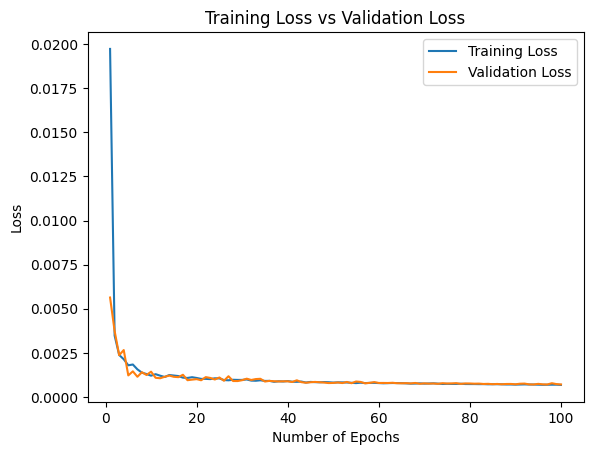

In [67]:
# Plot for Loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show

In [68]:
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
# Evaluar el modelo en el conjunto de validación
predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in valid_loader:
        inputs = inputs.to(device=device)
        targets = targets.to(device=device)

        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        true_values.append(targets.cpu().numpy())

# Convertir listas a arrays
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

# Calcular las métricas
mae = mean_absolute_error(true_values, predictions)
rmse = root_mean_squared_error(true_values, predictions)

print(f"Mean Absolute Error: {mae}") #0.08856
print(f"Root Mean Squared Error: {rmse}") #0.13405

Mean Absolute Error: 0.0007059797062538564
Root Mean Squared Error: 0.0010237334063276649


In [69]:
preds  = []
vals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device=device)
        targets = targets.to(device=device)

        outputs = model(inputs)
        preds.append(outputs.cpu().numpy())
        vals.append(targets.cpu().numpy())

test_preds = np.concatenate(preds)
test_values = np.concatenate(vals)

print(len(test_preds))

3155


In [70]:
for i in range(10): 
    print(f'Actual: {true_values[i]}')
    print(f'Predicted: {test_preds[i]}')
    print(80*'-')

Actual: [2.58448199e-06 5.60997523e-06 6.48103560e-06 5.68654923e-06
 4.96548728e-06 4.46650938e-06 4.63435344e-06 2.70821911e-05
 1.01831814e-04 2.69660435e-04 5.94562094e-04 1.12008175e-03
 1.55434269e-03 1.50635582e-03 1.44220784e-03 1.31664064e-03
 1.28016586e-03 1.54460850e-03 1.61647028e-03 2.10885424e-03]
Predicted: [-4.28706408e-05 -1.09530985e-04  3.27304006e-05  2.65818089e-05
 -5.37261367e-05  6.42230734e-05 -1.12131238e-05  1.19218603e-04
  1.57961156e-04  3.69320624e-04  6.40619546e-04  1.12934411e-03
  1.95211172e-03  2.61318311e-03  2.97248736e-03  3.55836703e-03
  4.47393954e-03  6.30489364e-03  7.15656020e-03  7.20931962e-03]
--------------------------------------------------------------------------------
Actual: [6.8228601e-06 6.8144182e-06 5.6936556e-06 4.5848642e-06 4.3617697e-06
 4.4964568e-06 7.6021306e-06 2.6820641e-04 8.8069186e-04 1.6054667e-03
 3.9856783e-03 6.5306365e-03 1.0367065e-02 1.3532326e-02 1.6306205e-02
 1.8656418e-02 2.0673618e-02 2.1751685e-02 2.19

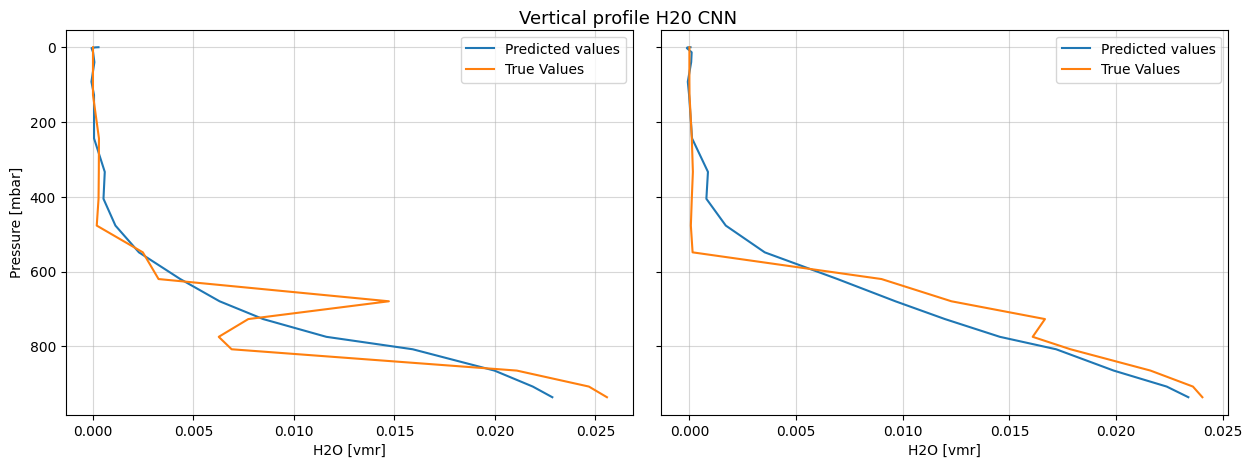

In [125]:
# Data
presiones = [1.5949503422e-01, 6.1677907944e-01, 2.6202105713e+00, 1.3643401489e+01, 4.0175408936e+01, 9.2365717773e+01, 1.2783702637e+02, 2.4388471558e+02, 3.3348357666e+02, 4.0541115967e+02, 4.7708076416e+02, 5.4860190674e+02, 6.1999756836e+02, 6.7943752563e+02, 7.2699364502e+02, 7.7449785034e+02, 8.0775010010e+02, 8.6473732971e+02, 9.0746744019e+02, 9.3596556274e+02]

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.gca().invert_yaxis()
fig.suptitle('Vertical profile H20 CNN', fontsize=13, y=0.92)
plt.subplots_adjust(wspace=0.05)
# Plot 1

axes[0].plot(test_preds[95], presiones, label='Predicted values')
axes[0].plot(test_values[95], presiones, label='True Values')
axes[0].set_xlabel('H2O [vmr]')
axes[0].set_ylabel('Pressure [mbar]')
axes[0].grid(True, alpha=0.5)
axes[0].legend()

# Plot 2
axes[1].plot(test_preds[80], presiones, label='Predicted values')
axes[1].plot(test_values[80], presiones, label='True Values')
axes[1].set_xlabel('H2O [vmr]')
axes[1].grid(True, alpha=0.5)
axes[1].legend()

plt.show()

In [72]:
import numpy as np

pearson_corrs = []
r2_scores = []

for i in range(test_values.shape[0]):
    pearson_corr = np.corrcoef(test_values[i], test_preds[i])[0, 1]
    r2 = pearson_corr ** 2
    pearson_corrs.append(pearson_corr)
    r2_scores.append(r2)

global_r2 = np.mean(r2_scores)

print(f"Global R² test: {global_r2}")

pearson_corrs = []
r2_scores = []

for i in range(true_values.shape[0]):
    pearson_corr = np.corrcoef(true_values[i], predictions[i])[0, 1]
    r2 = pearson_corr ** 2
    pearson_corrs.append(pearson_corr)
    r2_scores.append(r2)

global_r2 = np.mean(r2_scores)

print(f"Global R² validation: {global_r2}")

Global R² test: 0.9045080546802136
Global R² validation: 0.9017412584680652


In [21]:
torch.save(model.state_dict(), 'modelo.pth')